# NLP course project
**Summary**: Application of text classification approaches for Human Value Detection <br>
**Members**:
- Dell'Olio Domenico
- Delvecchio Giovanni Pio
- Disabato Raffaele  


The project was developed in order to create and test various models to address the task of Human Value Detection proposed in the challenge: <br>
https://touche.webis.de/semeval23/touche23-web/index.html <br>

The challenge can be tackled as a multi-label text clasification problem, thus we decided to implement and test various architectures in order to compare their performances. <br>
These architectures were either already present at the state of the art or were obtained as a result of experiments.

## This notebook contains the following implementations:
- GloVe baseline with two layers of Bi-GRU, followed by flatten and two dense layers with ReLU activation and a single dense layer with no activation;
- BERT baseline with two layers of Bi-LSTM (transfer learning), where the output cell states are concatenated and passed to a dense layer with ReLU activation and a single dense layer with no activation;
- finetuning of BERT followed by a dense layer with ReLU activation followed by a dense layer with no activation.

## This notebook does **not** contain:
- exstensive Data analysis (it is explored in the other notebook)

In [1]:
# installation of the required libraries
!pip install transformers
!pip install datasets
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [2]:
# Cell for the download of the datasets
!wget https://zenodo.org/record/7550385/files/arguments-training.tsv
!wget https://zenodo.org/record/7550385/files/labels-training.tsv
!wget https://zenodo.org/record/7550385/files/arguments-validation.tsv
!wget https://zenodo.org/record/7550385/files/labels-validation.tsv
!wget https://zenodo.org/record/7550385/files/arguments-test.tsv
!wget https://zenodo.org/record/7550385/files/arguments-validation-zhihu.tsv
!wget https://zenodo.org/record/7550385/files/labels-validation-zhihu.tsv

--2023-02-10 08:52:19--  https://zenodo.org/record/7550385/files/arguments-training.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1012498 (989K) [application/octet-stream]
Saving to: ‘arguments-training.tsv’

arguments-training. 100%[===================>] 988.77K  4.73MB/s    in 0.2s    

2023-02-10 08:52:19 (4.73 MB/s) - ‘arguments-training.tsv’ saved [1012498/1012498]

--2023-02-10 08:52:19--  https://zenodo.org/record/7550385/files/labels-training.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253843 (248K) [application/octet-stream]
Saving to: ‘labels-training.tsv’

labels-training.tsv 100%[===================>] 247.89K  --.-KB/s    in 0.05s   

2023-02-10 08:52:20 (4.71 MB/s) - ‘labels-training.tsv’ saved [253843

In [3]:
# imports for dataset loading
import numpy as np
import random
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# torch imports
import torch
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torchinfo import summary
from torch.optim import AdamW

#huggingface imports
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

# progress bar
from tqdm import tqdm
# garbage collector
import gc

# imports for evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [4]:
def fix_random(seed: int) -> None:
  """Fix all the possible sources of randomness.

  Params:
    seed: the seed to use. 
  """
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [5]:
# Cell needed to fix the seeds and define the available device
# for the training of the models
seed = 10
fix_random(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
def huggingface_from_pandas(pandas_df):
  """
  Function converting a pandas dataframe to a huggingface dataset.
  It also returns an ordered list containing the target labels

  Params:
    pandas_df: the dataset that has to be converted
  Returns:
    hf_ds:     the huggingface dataset obrained from pandas_df
    label_cols: the ordered list of target labels of pandas_df
  """

  hf_ds = Dataset.from_pandas(pandas_df, preserve_index=False)
  hf_ds = hf_ds.remove_columns(["Argument ID", "Argument ID2"])
  # Aggregating labels in a single list
  hf_ds = hf_ds.map(lambda x:{"labels": [int(x[col]) for col in hf_ds.column_names if
                                      col not in ['Conclusion', 'Stance', 'Premise']]})
  label_cols = [col for col in hf_ds.column_names if col not in ['Conclusion', 'Stance', 'Premise', "labels"]]
  # here we are removing the columns related to the labels from the dataset
  hf_ds = hf_ds.remove_columns(label_cols)
  return hf_ds, label_cols

The challenge provides the already splitted dataset in Train, Validation and Test splits. However the Test split does not have public labels available, 
so we decided to split the Training set in (Training, Validation) 
(with proportions 80-20 on unique conclusions) and to use the validation set as Test set.  <br>
We decided to probe the robustness of our model on the Chinese validation
set too, which has a different cultural background.

In [7]:
def train_test_split_wrt_conclusions(train, ratio = 0.8):
  """
  Function needed to perform the splits over the original train dataset,
  in order to obtain a train and a validation set which are divided by unique
  conclusions. The ratio parameter is needed in order to assign which portion 
  of the unique conclusions must be selected for the train split.
  
  Params:
    train: the original train set, to be splitted (Pandas dataframe)
    ratio: the proportion in (0, 1) of unique conclusions to be inserted in 
           the training dataframe.
  Returns:
    train_set_to_return: the portion of train that contains ratio unique
                         conclusions.
    val_set_to_return: the proportion of the train that contains 1 - ratio
                       unique conclusions (the remaining ones)
  """
  val = []
  unique_conc = pd.unique(train["Conclusion"])
  num_train_con = int(len(unique_conc)*ratio)
  train_unique_conc = np.random.choice(unique_conc, num_train_con, replace = False)
  val_unique_conc = set(unique_conc) - set(train_unique_conc)
  train_set_to_return = train[train.Conclusion.isin(train_unique_conc)] 
  val_set_to_return = train[train.Conclusion.isin(val_unique_conc)]
  return train_set_to_return, val_set_to_return

In [8]:
# Dataset loading and splitting
raw_training = pd.read_csv("arguments-training.tsv", encoding='utf-8', sep='\t', header=0)
raw_training_lab = pd.read_csv("labels-training.tsv", encoding='utf-8', sep='\t', header=0)
raw_test = pd.read_csv("arguments-validation.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_lab = pd.read_csv("labels-validation.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_chn=pd.read_csv("arguments-validation-zhihu.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_chn_lab=pd.read_csv("labels-validation-zhihu.tsv", encoding='utf-8', sep='\t', header=0)

train = raw_training.join(raw_training_lab,how='inner' ,lsuffix='2') # joining labels
test = raw_test.join(raw_test_lab, how='inner', lsuffix='2') # joining labels
test_chn = raw_test_chn.join(raw_test_chn_lab, how='inner', lsuffix='2') # joining labels
fix_random(seed)
train, val = train_test_split_wrt_conclusions(train) # splitting training

train_ds, label_list = huggingface_from_pandas(train)
val_ds, _ = huggingface_from_pandas(val)
test_ds, _ = huggingface_from_pandas(test)
test_chn_ds, _ = huggingface_from_pandas(test_chn) 

print("Single example from the training dataset: ")
print(train_ds[0])
print("Full list of target labels: ")
print(label_list)
num_classes = len(label_list)
print("Total number of target labels: ")
print(num_classes)
whole_dataset = DatasetDict()
whole_dataset["train"] = train_ds.with_format("torch")
whole_dataset["val"] = val_ds.with_format("torch")
whole_dataset["test"] = test_ds.with_format("torch")
whole_dataset["test_chn"] = test_chn_ds.with_format("torch")

  0%|          | 0/4176 [00:00<?, ?ex/s]

  0%|          | 0/1217 [00:00<?, ?ex/s]

  0%|          | 0/1896 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Single example from the training dataset: 
{'Conclusion': 'We should ban human cloning', 'Stance': 'in favor of', 'Premise': 'we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.', 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Full list of target labels: 
['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']
Total number of target labels: 
20


In [56]:
print(len(train_ds))

4176


In [9]:
def make_predictions(model, loader):
  """
  Function needed to obtain the prediction for the target labels
  given a model and a data loader.

  Params:
    model: the model that will be used to obtain the predictions over
           the labels
    loader: the data loader needed to feed the model with the data for which
            we want to obtain label predictions
  Returns:
    Y_preds: tensor containing the predicted label for each example.
             These labels are obtained as the output of the model passed to
             a sigmoid function.
  """
  Y_preds = []
  model.eval()
  for X, Y in loader:
    with torch.no_grad():
      preds = model(X)
    Y_preds.append(preds)
  gc.collect()
  Y_preds = torch.cat(Y_preds)
  Y_preds = Y_preds.sigmoid()
  return Y_preds.detach()

def keep_above_thresh(Y_preds, thr):
  """
  Function needed to convert the results of the models to hard labels
  using a threshold.
  
  Params:
    Y_preds: scores obtained by the model which have to be converted to hard
             labels
    thr: threshold to be applied to the scores, element of (0, 1), if a score
         is greater than thr it becomes a hard label with value 1, 
         0 otherwise
  Retuns:
    Y_preds_thr: hard labels obtained by thresholding Y_preds with thr
  """
  Y_preds_thr = np.copy(Y_preds.numpy())
  max_rows = Y_preds_thr.shape[0]
  max_cols = Y_preds_thr.shape[1]
  for i in range(max_rows):
    new_row = np.array([1 if Y_preds_thr[i][j] > thr else 0 for j in range(max_cols)])
    Y_preds_thr[i] = new_row
  return Y_preds_thr

def compute_macro_score(M_true, M_pred, score_func):
  """
  Function needed to compute the macro aggregation of a scored function
  over the different classes.

  Params:
    M_true: true labels needed to compute the scores
    M_pred: predicted labels needed to compute the scores
    score_func: scoring function to be computed
  Returns:
    macro: aggregation of the result of score_func computed over all the
           labels.
    scores: list of per-label score
  """
  scores = []
  for i in range(M_true.shape[1]):
      true = M_true[:, i]
      pred = M_pred[:, i]
      if score_func == accuracy_score:
        scores.append(score_func(true, pred))
      else: 
        scores.append(score_func(true, pred, zero_division=0))
  macro = np.mean(scores)
  return macro, scores
  
def support(true, pred, zero_division):
  """
  Utility function to compute the support of the class labels,
  pred and zero_division are dummy parameters needed to have conformity
  with the sklearn functions to compute scores.

  Params: 
    true: binary true labels for a single class for each example that are needed
          to compute the support for the single class
    pred: dummy parameter
    zero_division: dummy parameter
  Returns:
    sum(true): the number of example for a single class (support)
  """
  return sum(true)

def print_report(classifier, loader, y_true, threshold, labels=label_list):
  """
  Function needed to print the classification results given a classifier,
  a dataset loader, true labels and a threshold. 
  The printed report includes macro accuracy, precision, recall and F1, as 
  well as per-class accuracy, precision, recall, F1 and support.

  Params:
    classifier: the model that has to be evaluated
    loader: data-loader needed to feed the data to the classifier to get 
            predicted labels
    y_true: true labels associated to the dataset associated to the loader
    threshold: threshold for the conversion of the scores to hard labels,
               check keep_above_thresh for further details
    labels: ordered list of target labels. Defaults to the list extracted from
            the dataset
  """

  Y_preds = make_predictions(classifier, loader)
  Y_preds_thr = keep_above_thresh(Y_preds.to('cpu'), threshold)

  f1_macro, f1 = compute_macro_score(y_true, Y_preds_thr, f1_score)
  acc_macro, acc = compute_macro_score(y_true, Y_preds_thr, accuracy_score)
  prec_macro, prec = compute_macro_score(y_true, Y_preds_thr, precision_score)
  rec_macro, rec = compute_macro_score(y_true, Y_preds_thr, recall_score)
  _, sup = compute_macro_score(y_true, Y_preds_thr, support)

  print("----- MACRO AVG. -----")
  print(f"  F1-score:\t{round(f1_macro,4)}\n\
  Precision:\t{round(prec_macro,4)}\n\
  Recall:\t{round(rec_macro,4)}\n\
  Accuracy:\t{round(acc_macro,4)}")
  print("----- PER-CLASS VALUES -----")
  print("  \t\t\t\tF1-score\tPrecision\tRecall\t\tAccuracy\tSupport")
  for i in range(len(labels)):
    print("  " + labels[i]+" "*(len(max(labels, key=len))-len(labels[i])), end="\t")
    print(f"{round(f1[i],4)}\t\t{round(prec[i],4)}\t\t{round(rec[i],4)}\t\t{round(acc[i],4)}\t\t{sup[i]}")

## GloVe model
The first model that was developed is a GloVe 100d embedding + two Bi-GRU layers
That serves as an advanced baseline to perfom experiments for multi-label classification problems like the current one. 
It is still a baseline since it has a simple architecture, OOV are treated using zero-vectors, the hidden states of the Bi-GRU layers are initialized 
as zero-vectors and most importantly the model does not work with contextual information, but only with the semantics of the words. <br>
Moreover an heavy preprocessing to the dataset is not applied except for lowercasing the arguments, tokenization and the addition of truncation and padding because the GloVe embeddings would return too many unmasked zero vectors. <br>
About padding and truncation: the maximum allowed length is 35 which is 
slightly above the sum of the mean token length value for the premises and the
conclusion. 

N.B.: the last dense layer has no activation for all the models, since the loss
function applies it by guaranteeing numerical stability. Thus the output of the
layer must be passed to a sigmoid function before converting it to labels.

In [10]:
# Pretrained GloVe setup

global_vectors = GloVe(name='6B', dim=100)

# the current choice is to give an id to each word
tokenizer = get_tokenizer("basic_english")

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 25887.48it/s]


In [11]:
# these parameters are used both by the following function and by the 
# implementation of the GloVe model itself, thus are kept global
max_words_emb = 35
embed_len = 100

# collate function where the Premises are tokenized and embedded in batches
def vectorize_batch(batch):
  """
  Collate function to preprocess the data for the GloVe model.
  In particular it joins premises, stances and conclusions in the same string,
  tokenizes, truncates and pads them and then converts each token to a GloVe
  vector. Target labels are already one-hot encoded.

  Params:
    batch: batch of data to be preprocessed
  Returns:
    X_tensor: a tensor containing GloVe vectors of dimension 100, which has shape
              (batch_size, max_words_emb, embed_len)
    Y_tensor: a tensor containing labels, which has shape
              (batch_size, num_classes)
  """
  X = [elem["Premise"] + " " + elem["Stance"] + " " +elem["Conclusion"] for elem in batch]
  Y = [elem["labels"] for elem in batch]
  X = [tokenizer(x) for x in X]
  X = [tokens+[""] * (max_words_emb-len(tokens))  if len(tokens)<max_words_emb else tokens[:max_words_emb] for tokens in X]
  X_tensor = torch.zeros(len(batch), max_words_emb, embed_len)
  Y_tensor = torch.zeros(len(batch), Y[0].shape[0])
  for i, tokens in enumerate(X):
      X_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
      Y_tensor[i] = Y[i]
  return X_tensor, Y_tensor

In [12]:
# Simple model to perform some tests with pytorch
class EmbeddingClassifier(nn.Module):
  """
  Class implementing the GloVe model.
  Remark: max_words_emb, embed_len and num_classes are parameters
          used to create this architecture which are set outside the class.
  """
  def __init__(self):
      super(EmbeddingClassifier, self).__init__() 
      
      self.gru_layers = 2

      self.gru = nn.GRU(input_size = embed_len,
                        hidden_size = embed_len,
                        num_layers = self.gru_layers,
                        batch_first=True, 
                        bidirectional = True)
      self.flatten = nn.Flatten(start_dim=1)
      self.linear_1 = nn.Linear(max_words_emb*embed_len*2, 512)
      self.relu = nn.ReLU()
      self.linear_2 = nn.Linear(512,128)
      self.linear_3 = nn.Linear(128, num_classes)
      
              

  def forward(self, X_batch):
    """
    It is important to note that the initial hidden states of the GRU
    layers are initialized with zero tensors.

    The outcomes of the GRU layers are flattened and classified. 
    """
    h0 = torch.zeros(2*self.gru_layers,X_batch.shape[0], embed_len)
    h0 = h0.to(device)
    out, hn = self.gru(X_batch, h0)
    out = self.flatten(out)
    out = self.linear_1(out)
    out = self.relu(out)
    out = self.linear_2(out)
    out = self.relu(out)
    out = self.linear_3(out)
    return out

# Function needed to compute the validation loss and the accuracy
def compute_validation_loss(model, loss_fn, val_loader):
  """
  Function computing and printing the loss on the validation set.
  Params:
    model: the model for which the loss must be computed and printed
    loss_fn: the loss function to adopt
    val_loader: dataloader for the validation set

  Returns:
    loss: the computed mean loss across the batch
  """

  with torch.no_grad():
    losses = []
    for X, Y in val_loader:
      preds = model(X)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

    loss = torch.tensor(losses).mean()
    print("Valid Loss : {:.3f}".format(loss))
  return loss


# Training function
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs, early_stopping_info, model_name):
  """
  Function for model training. If early stopping info is defined it saves the 
  last best models and eventually returns it, in case of early stopping.
  In case early_stopping_info is not defined, the early stopping is not
  applied.

  Params:
    model: the model that has to be trained
    loss_fn: the loss function to adopt in order to perform the training
    optimizer: the optimizer to be used for training
    train_loader: the dataloader for the training dataset
    val_loader: the dataloader for the validation dataset
    epochs: the number of epochs for training
    early_stopping_info: dictionary containing the parameters for the early stopping:
                          - delta: min acceptable improvement in the validation loss
                          - patience: number of epochs to wait for improvement
    model_name: string containing the name of the model (used in order to save
                the weights)
  Returns:
    model: the trained model
  """
  patience_acc = 0
  precedent_loss = np.Inf
  model.train()
  for i in range(1, epochs+1):
      losses = []
      for X, Y in tqdm(train_loader):

          Y_preds = model(X)

          loss = loss_fn(Y_preds, Y)
          losses.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      loss = compute_validation_loss(model, loss_fn, val_loader)
      print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
      if early_stopping_info != None:
        if precedent_loss - loss < early_stopping_info["delta"]:
            patience_acc = patience_acc + 1
        else:
          patience_acc = 0
          precedent_loss = loss  
          torch.save(model, model_name + "_best.pth")

        if patience_acc >= early_stopping_info["patience"]:
          return torch.load(model_name + "_best.pth")           
  return model


### Training informations
The training was performed considering a maximum of 50 epochs with the following parameters for early stopping: patience equal to 3 epochs and delta equal to 1e-4. Batch size, learning rate and number of parameters for the layers were tuned by hand considering the results on the validation set.
In particular the following pools were considered:
- batch_size in \{16, 32, 64\}
- learning rate in \{1e-2, 1e-3, 1e-4\}
- hidden size of the GRU layers in \{100, 200\}
- neurons of the linear layers in \{512, 256, 128\}

In [13]:
epochs = 50
learning_rate = 1e-4
batch_size = 32

loss_fn = nn.BCEWithLogitsLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

# Construction of the Dataloaders for train and validation
train_loader = DataLoader(whole_dataset["train"], batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in vectorize_batch(x)))
val_loader  = DataLoader(whole_dataset["val"], batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in vectorize_batch(x)))
test_loader  = DataLoader(whole_dataset["test"], batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in vectorize_batch(x)))


embed_classifier.to(device)
summary(embed_classifier, 
                input_data=next(iter(train_loader))[0],
                device=device)


Layer (type:depth-idx)                   Output Shape              Param #
EmbeddingClassifier                      [32, 20]                  --
├─GRU: 1-1                               [32, 35, 200]             302,400
├─Flatten: 1-2                           [32, 7000]                --
├─Linear: 1-3                            [32, 512]                 3,584,512
├─ReLU: 1-4                              [32, 512]                 --
├─Linear: 1-5                            [32, 128]                 65,664
├─ReLU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 20]                  2,580
Total params: 3,955,156
Trainable params: 3,955,156
Non-trainable params: 0
Total mult-adds (M): 455.58
Input size (MB): 0.45
Forward/backward pass size (MB): 1.96
Params size (MB): 15.82
Estimated Total Size (MB): 18.23

In [14]:
fix_random(seed)
embed_classifier = TrainModel(embed_classifier, loss_fn, optimizer, train_loader, val_loader, epochs, {"patience": 3, "delta": 1e-4}, "glove")

100%|██████████| 131/131 [00:03<00:00, 33.01it/s]


Valid Loss : 0.410
Train Loss : 0.454


100%|██████████| 131/131 [00:02<00:00, 54.03it/s]


Valid Loss : 0.406
Train Loss : 0.416


100%|██████████| 131/131 [00:03<00:00, 40.45it/s]


Valid Loss : 0.397
Train Loss : 0.403


100%|██████████| 131/131 [00:02<00:00, 53.04it/s]


Valid Loss : 0.390
Train Loss : 0.388


100%|██████████| 131/131 [00:03<00:00, 38.59it/s]


Valid Loss : 0.383
Train Loss : 0.377


100%|██████████| 131/131 [00:02<00:00, 53.48it/s]


Valid Loss : 0.377
Train Loss : 0.370


100%|██████████| 131/131 [00:02<00:00, 54.27it/s]


Valid Loss : 0.372
Train Loss : 0.364


100%|██████████| 131/131 [00:02<00:00, 54.77it/s]


Valid Loss : 0.370
Train Loss : 0.358


100%|██████████| 131/131 [00:03<00:00, 37.69it/s]


Valid Loss : 0.367
Train Loss : 0.353


100%|██████████| 131/131 [00:02<00:00, 54.72it/s]


Valid Loss : 0.366
Train Loss : 0.348


100%|██████████| 131/131 [00:02<00:00, 55.09it/s]


Valid Loss : 0.366
Train Loss : 0.343


100%|██████████| 131/131 [00:02<00:00, 54.84it/s]


Valid Loss : 0.365
Train Loss : 0.338


100%|██████████| 131/131 [00:03<00:00, 36.30it/s]


Valid Loss : 0.365
Train Loss : 0.334


100%|██████████| 131/131 [00:02<00:00, 54.44it/s]


Valid Loss : 0.366
Train Loss : 0.329


100%|██████████| 131/131 [00:02<00:00, 54.49it/s]


Valid Loss : 0.368
Train Loss : 0.323


In [15]:
print("GloVe BASELINE:")
print_report(embed_classifier, val_loader, whole_dataset["val"]["labels"], 0.25)

GloVe BASELINE:
----- MACRO AVG. -----
  F1-score:	0.3092
  Precision:	0.3175
  Recall:	0.3847
  Accuracy:	0.789
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.2986		0.2374		0.4024		0.8726		82
  Self-direction: action    	0.4658		0.379		0.6041		0.6664		293
  Stimulation               	0.0		0.0		0.0		0.9647		43
  Hedonism                  	0.0		0.0		0.0		0.9737		32
  Achievement               	0.5928		0.5409		0.6556		0.7313		363
  Power: dominance          	0.2525		0.3521		0.1969		0.8784		127
  Power: resources          	0.5103		0.7025		0.4007		0.825		277
  Face                      	0.0213		0.2		0.0112		0.9244		89
  Security: personal        	0.6223		0.4754		0.9008		0.5472		504
  Security: societal        	0.679		0.6084		0.7682		0.7297		453
  Tradition                 	0.2537		0.2203		0.2989		0.8743		87
  Conformity: rules         	0.4503		0.3239		0.7384		0.5867		279
  Conformity: interpersonal 	0.0		0.0		0.0		0.954		56
  H

## BERT + LSTM model (transfer learning)
The following model is proposed to enhance the GloVe model through the following changes:
- Usage of contextual frozen Bert encoding instead of GloVe embeddings
(changes were performed in the collate)
- Substitution of the GRU layers with LSTM layers, which are more complex. 
- Meaningful initialization of the LSTM hidden and cell states using
the pooler-output of the BERT encoding of an argument passed to two different dense layers (ideally the pooler-output represents the encoding of the \[CLS\] token which is at the beginning of every argument and contains general informations about semantics of the whole sentence).
- Classification focussed on the concatenation of the output cell states of the LSTM layers, rather than the encoding of the whole sentence (concatenation of the hidden states).
This reduces the number of required neurons and elaborates a tensor that retains the most important semantic informations on the sentence.

### Selection of the BERT model
For this task we used the bert-based-uncased model and tokenizer. 
We also decided to try different variations of BERT (ELECTRA, ALBERT, Funnel Transformer, ...), but we didn't obtain remarkable improvements.

In [16]:
# import of the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
print("Bert loaded")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Bert loaded


The choice for the maximum length of the BERT encodings is 70 because
it is slightly above the sum of the 90-th percentile of the lengths of premises, stances and conclusions.
It is longer with respect to the maximum number of words for the GloVe model,
since BERT-encoded vectors are much more dense.

In [17]:
max_words_bert = 70
# collate function that uses the tokenizer relative to the bert pretrained model
def bert_vectorize_batch(batch):
  """
  Collate function to preprocess the data for the BERT-based models.
  In particular it joins premises, stances and conclusions in the same string,
  separated by the [SEP] token.
  Using the appropriate tokenizer, arguments are tokenized, truncated and padded.
  Target labels are already one-hot encoded.

  Params:
    batch: batch of data to be preprocessed
  Returns:
    X_tensor: a tensor containing a torch tensor containing the input_ids, the token_type_ids and the
              attention_mask for each example of the batch, which has shape:
              (3, batch_size, max_words_bert)
    Y_tensor: a tensor containing labels, which has shape
              (batch_size, num_classes)
  """
  X = [elem["Premise"] + " [SEP] " + elem["Stance"] + " [SEP] " + elem["Conclusion"] for elem in batch]
  Y = [elem["labels"] for elem in batch]
  X = bert_tokenizer(X, padding="max_length", truncation="longest_first", return_tensors = "pt", max_length = max_words_bert) 
  Y_tensor = torch.zeros(len(batch), Y[0].shape[0])
  for i, tokens in enumerate(Y):    
      Y_tensor[i] = Y[i]
  X_tensor = torch.stack([X["input_ids"], X["token_type_ids"], X["attention_mask"]])

  return X_tensor, Y_tensor

train_dataset = whole_dataset["train"]
val_dataset = whole_dataset["val"] 
test_dataset = whole_dataset["test"] 

In [18]:
# Simple model to perform some tests with pytorch
class BertLSTM(nn.Module):
  """
  Class implementing the BERT + LSTM model.
  Remark: max_words_bert and num_classes are parameters
          used to create this architecture which are set outside the class.
  """
  def __init__(self, bert_model):
    # the single parameter of this init function is the bert model 
    # that has to be used for transfer learning
    super(BertLSTM, self).__init__() 
    self.lstm_layers = 2
    self.lstm_hs = 128 # hidden size of the lstm
    bert_hidden_size = bert_model.config.hidden_size

    # freezing the parameters for the BERT model
    self.bert_model = bert_model
    for param in self.bert_model.parameters():
        param.requires_grad = False

    self.lstm = nn.LSTM(input_size=bert_hidden_size,
                        hidden_size=self.lstm_hs,
                        num_layers=self.lstm_layers ,
                        batch_first=True,
                        bidirectional=True)
    self.reducer_c0 = nn.Linear(bert_hidden_size, self.lstm_hs)
    self.reducer_h0 = nn.Linear(bert_hidden_size, self.lstm_hs)
    self.linear_1 = nn.Linear(self.lstm_hs*2*self.lstm_layers, self.lstm_hs)
    self.relu = nn.ReLU()
    self.linear_2 = nn.Linear(self.lstm_hs, num_classes) # since the dimensions
    # are already small there is no need for a third linear layer

  def forward(self, X_batch):
    #Remark: The LSTM layer does not contain the encoding of the [CLS] token
    #since it is used to initialize the hidden and cell states.
    out = self.bert_model(input_ids=X_batch[0], token_type_ids = X_batch[1], attention_mask = X_batch[2])
    cell = self.reducer_c0(out.pooler_output)
    hidden = self.reducer_h0(out.pooler_output)
    out = out.last_hidden_state[:,1:,:]
    c0 = torch.stack([cell,cell,cell,cell]) 
    h0 = torch.stack([hidden, hidden, hidden, hidden])
    out_lstm, hc_n  = self.lstm(out, (h0, c0))
    c_n = hc_n[1].permute(1, 0, 2) # permutation in order to obtain the batch 
                                   # size dimension first
    out = torch.cat([c_n[:,0,:], c_n[:,1,:]], 1) # concatenation of the cell states
    out2 = torch.cat([c_n[:,2,:], c_n[:,3,:]], 1)
    out = torch.cat([out, out2], 1)
    out = self.linear_1(out)
    out = self.relu(out)
    out = self.linear_2(out)
    return out

### Training informations
The training was performed considering a maximum of 50 epochs with the following parameters for early stopping: patience equal to 3 epochs and delta equal to 1e-4. Batch size, learning rate and number of parameters for the layers were tuned by hand considering the results on the validation set.
In particular the following pools were considered:
- batch_size in \{16, 32, 64\}
- learning rate in \{1e-2, 1e-3, 1e-4\}
- hidden size of the LSTM layers in \{128, 256, 512\}
- neurons of the linear layers in \{256, 128\}

In [19]:
batch_size = 32
epochs = 50
learning_rate = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
prebert_classifier = BertLSTM(bert_model)
optimizer = Adam(prebert_classifier.parameters(), lr=learning_rate)

bert_train_loader = DataLoader(whole_dataset["train"], batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))
bert_val_loader  = DataLoader(whole_dataset["val"], batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))
bert_test_loader  = DataLoader(whole_dataset["test"], batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))

prebert_classifier.to(device)
summary(prebert_classifier, 
                input_data=next(iter(bert_train_loader))[0],
                device=device)

Layer (type:depth-idx)                                  Output Shape              Param #
BertLSTM                                                [32, 20]                  --
├─BertModel: 1-1                                        [32, 768]                 --
│    └─BertEmbeddings: 2-1                              [32, 70, 768]             --
│    │    └─Embedding: 3-1                              [32, 70, 768]             (23,440,896)
│    │    └─Embedding: 3-2                              [32, 70, 768]             (1,536)
│    │    └─Embedding: 3-3                              [1, 70, 768]              (393,216)
│    │    └─LayerNorm: 3-4                              [32, 70, 768]             (1,536)
│    │    └─Dropout: 3-5                                [32, 70, 768]             --
│    └─BertEncoder: 2-2                                 [32, 70, 768]             --
│    │    └─ModuleList: 3-6                             --                        (85,054,464)
│    └─BertPooler: 2-3 

In [20]:
fix_random(seed)
prebert_classifier = TrainModel(prebert_classifier, loss_fn, optimizer, bert_train_loader, bert_val_loader, epochs, {"patience": 3, "delta": 1e-4}, "bertencoder")

100%|██████████| 131/131 [00:21<00:00,  6.20it/s]


Valid Loss : 0.381
Train Loss : 0.396


100%|██████████| 131/131 [00:21<00:00,  6.17it/s]


Valid Loss : 0.372
Train Loss : 0.343


100%|██████████| 131/131 [00:23<00:00,  5.64it/s]


Valid Loss : 0.368
Train Loss : 0.324


100%|██████████| 131/131 [00:22<00:00,  5.80it/s]


Valid Loss : 0.366
Train Loss : 0.309


100%|██████████| 131/131 [00:22<00:00,  5.89it/s]


Valid Loss : 0.367
Train Loss : 0.294


100%|██████████| 131/131 [00:22<00:00,  5.93it/s]


Valid Loss : 0.377
Train Loss : 0.280


100%|██████████| 131/131 [00:21<00:00,  6.01it/s]


Valid Loss : 0.391
Train Loss : 0.266


In [21]:
print("BERT+LSTM:")
print_report(prebert_classifier, bert_val_loader, whole_dataset["val"]["labels"], 0.25)

BERT+LSTM:
----- MACRO AVG. -----
  F1-score:	0.3546
  Precision:	0.3797
  Recall:	0.4145
  Accuracy:	0.8014
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.3012		0.2976		0.3049		0.9047		82
  Self-direction: action    	0.4711		0.3833		0.6109		0.6697		293
  Stimulation               	0.0952		0.15		0.0698		0.9532		43
  Hedonism                  	0.2609		0.4286		0.1875		0.9721		32
  Achievement               	0.6343		0.5469		0.7548		0.7403		363
  Power: dominance          	0.1625		0.3939		0.1024		0.8899		127
  Power: resources          	0.4206		0.596		0.3249		0.7962		277
  Face                      	0.1639		0.303		0.1124		0.9162		89
  Security: personal        	0.6879		0.6218		0.7698		0.7108		504
  Security: societal        	0.6891		0.6593		0.7219		0.7576		453
  Tradition                 	0.2125		0.2329		0.1954		0.8965		87
  Conformity: rules         	0.4882		0.3425		0.8495		0.5916		279
  Conformity: interpersonal 	0.0		0.0		0.

## BERT fine tuning
The following model is simply a fine tuned version of the BERT model on the reference dataset and it is proposed as an alternative to the previous models.
In particular a similar model has been proposed by the authors of the dataset, hence it can be used as a reference point, since the datasets are not exacly equal.

The architecture is a simple fine tuning of BERT followed by two linear layers which elaborate its pooler-output and reduce its dimension to num_classes.
It is a common architecture that employs BERT in order to perform multi-label text classification.

In [22]:
# Simple model to perform some tests with pytorch
class FineTunedBert(nn.Module):
  """
  Class implementing the model that allows to fine-tune BERT for this task.
  Remark: max_words_bert and num_classes are parameters
          used to create this architecture which are set outside the class.
  """
  def __init__(self, bert_model):
    # the single parameter of this init function is the bert model 
    # that has to be used for fine-tuning
    super(FineTunedBert, self).__init__() 
    self.bert_model = bert_model
    for param in self.bert_model.parameters():
        param.requires_grad = True
    bert_hidden_size = bert_model.config.hidden_size
    self.linear_1 = nn.Linear(bert_hidden_size, bert_hidden_size//2)
    self.relu = nn.ReLU()
    self.linear_2 = nn.Linear(bert_hidden_size//2, num_classes)

  def forward(self, X_batch):
    out = self.bert_model(input_ids=X_batch[0], 
                          token_type_ids = X_batch[1],
                          attention_mask = X_batch[2])

    out = out.last_hidden_state[:,0,:]
    out = self.linear_1(out)
    out = self.relu(out)
    out = self.linear_2(out)
    return out

# Training function
def finetune_bert(model, loss_fn, optimizer, train_loader, val_loader, epochs, early_stopping_info, model_name, scheduler):
  """
  Training function for the fine-tuning of BERT. if arly_stopping_info info is set
  to None, early stopping is not performed.
  Params:
    model: the model that has to be fine-tuned
    loss_fn: the loss function to adopt in order to perform the training
    optimizer: the optimizer to be used for training
    train_loader: the dataloader for the training dataset
    val_loader: the dataloader for the validation dataset
    epochs: the number of epochs for training
    early_stopping_info: dictionary containing the parameters for the early stopping:
                          - delta: min acceptable improvement in the validation loss
                          - patience: number of epochs to wait for improvement
    model_name: string containing the name of the model (used in order to save
                the weights)
    scheduler: the learning rate scheduler to be applied (it is a step scheduler)
  Returns:
    model: the trained model
  """
  patience_acc = 0
  precedent_loss = np.Inf
  model.train()
  for i in range(1, epochs+1):
      losses = []
      for X, Y in tqdm(train_loader):
          model.zero_grad()
          Y_preds = model(X)
          loss = loss_fn(Y_preds, Y)
          losses.append(loss.item())

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

      loss = compute_validation_loss(model, loss_fn, val_loader)
      print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
      if early_stopping_info != None:
        if precedent_loss - loss < early_stopping_info["delta"]:
            patience_acc = patience_acc + 1
        else:
          patience_acc = 0
          precedent_loss = loss
          torch.save(model, model_name + "_best.pth")

        if patience_acc > early_stopping_info["patience"]:
          return torch.load(model_name + "best.pth")
  return model

In [23]:
bert_model_unfrozen = BertModel.from_pretrained('bert-base-uncased')
bert_model_unfrozen.to(device)
print("reloaded")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


reloaded


## Training informations
The training recipe and the model were adapted from the following tutorial:<br>
https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
<br>
As suggested in the tutorial the AdamW optimizer was used, the gradients were clipped to 1 and hyperparameters were drawn from the following pools:
- batch_size in \{16, 32\}
- learning rate in {5e-5, 3e-5, 2e-5}
- number of epochs in \{2, 3, 4\}, but also 5 and 6 were tested. With 6 epochs the validation loss goes a little bit up, but returns better F1 scores.
- the number of neurons of the linear layers are obtained by progressively halving the output of the BERT model

In [24]:
batch_size = 16
epochs = 6
learning_rate = 5e-5

loss_fn = nn.BCEWithLogitsLoss()

finetune_classifier = FineTunedBert(bert_model_unfrozen)
optimizer = AdamW(finetune_classifier.parameters(), lr=learning_rate, eps=1e-8)


bert_train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))
bert_val_loader  = DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))
bert_test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(bert_train_loader)*epochs)

finetune_classifier.to(device)
summary(finetune_classifier, input_data=next(iter(bert_train_loader))[0], device=device, dtypes = [torch.int]*3)

Layer (type:depth-idx)                                  Output Shape              Param #
FineTunedBert                                           [16, 20]                  --
├─BertModel: 1-1                                        [16, 768]                 --
│    └─BertEmbeddings: 2-1                              [16, 70, 768]             --
│    │    └─Embedding: 3-1                              [16, 70, 768]             23,440,896
│    │    └─Embedding: 3-2                              [16, 70, 768]             1,536
│    │    └─Embedding: 3-3                              [1, 70, 768]              393,216
│    │    └─LayerNorm: 3-4                              [16, 70, 768]             1,536
│    │    └─Dropout: 3-5                                [16, 70, 768]             --
│    └─BertEncoder: 2-2                                 [16, 70, 768]             --
│    │    └─ModuleList: 3-6                             --                        85,054,464
│    └─BertPooler: 2-3           

In [25]:
fix_random(seed)
finetune_classifier = finetune_bert(finetune_classifier, 
                                   loss_fn, optimizer,
                                   bert_train_loader,
                                   bert_val_loader,
                                   epochs,
                                   None, 
                                   "finebert", scheduler)

100%|██████████| 261/261 [01:01<00:00,  4.22it/s]


Valid Loss : 0.375
Train Loss : 0.404


100%|██████████| 261/261 [01:00<00:00,  4.28it/s]


Valid Loss : 0.346
Train Loss : 0.323


100%|██████████| 261/261 [01:00<00:00,  4.30it/s]


Valid Loss : 0.337
Train Loss : 0.278


100%|██████████| 261/261 [01:00<00:00,  4.30it/s]


Valid Loss : 0.340
Train Loss : 0.241


100%|██████████| 261/261 [01:00<00:00,  4.32it/s]


Valid Loss : 0.348
Train Loss : 0.211


100%|██████████| 261/261 [01:00<00:00,  4.32it/s]


Valid Loss : 0.347
Train Loss : 0.193


In [26]:
print("FINETUNED BERT:")
print_report(finetune_classifier, bert_val_loader, whole_dataset["val"]["labels"], 0.25)

FINETUNED BERT:
----- MACRO AVG. -----
  F1-score:	0.4093
  Precision:	0.4833
  Recall:	0.4225
  Accuracy:	0.8433
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.3969		0.2914		0.622		0.8726		82
  Self-direction: action    	0.562		0.5203		0.6109		0.7707		293
  Stimulation               	0.1132		0.3		0.0698		0.9614		43
  Hedonism                  	0.2564		0.7143		0.1562		0.9762		32
  Achievement               	0.6394		0.5672		0.7328		0.7535		363
  Power: dominance          	0.2553		0.3934		0.189		0.885		127
  Power: resources          	0.6087		0.6109		0.6065		0.8225		277
  Face                      	0.0632		0.5		0.0337		0.9269		89
  Security: personal        	0.7166		0.6644		0.7778		0.7453		504
  Security: societal        	0.7126		0.6766		0.7528		0.774		453
  Tradition                 	0.323		0.3514		0.2989		0.9104		87
  Conformity: rules         	0.5231		0.4713		0.5878		0.7543		279
  Conformity: interpersonal 	0.0656		0.4		0.

## Evaluation of the models
As also indicated in the paper describing the dataset, the task of extracting values from arguments is inevitabily dependant on the cultural background of the people expressing them. For this reason, the models are evalueted both on our test split (original validation split) and on the dataset split extracted by a chinese-background source.
The reference evaluation scores are the macro F1s, but we also provide macro inter-class precision, recall and accuracy.
We also tuned the threshold needed to obtain hard labels. The default should be 0.5, but we decided to lower it to 0.25 in order to sacrifice a bit of precision and gain an improvement to the recall and thus obtain a better F1 score. 
Since the threshold is an hyperparameter of the model, tuning was **not** meant to be a way to artifically increase F1-scores.

### Evaluation on the set with the same cultural background
We first present and discuss the results on the dataset with same source as the training dataset.

In [30]:
print("GloVe BASELINE:")
print_report(embed_classifier, test_loader, whole_dataset["test"]["labels"], 0.25)

GloVe BASELINE:
----- MACRO AVG. -----
  F1-score:	0.3205
  Precision:	0.4084
  Recall:	0.3944
  Accuracy:	0.7883
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.3327		0.3134		0.3546		0.8117		251
  Self-direction: action    	0.4677		0.3729		0.627		0.6266		496
  Stimulation               	0.0284		0.6667		0.0145		0.9277		138
  Hedonism                  	0.0377		0.6667		0.0194		0.9462		103
  Achievement               	0.5364		0.497		0.5826		0.6946		575
  Power: dominance          	0.2591		0.3855		0.1951		0.9035		164
  Power: resources          	0.4324		0.3902		0.4848		0.9114		132
  Face                      	0.0153		1.0		0.0077		0.932		130
  Security: personal        	0.6647		0.5284		0.8959		0.6382		759
  Security: societal        	0.555		0.4833		0.6516		0.731		488
  Tradition                 	0.338		0.3279		0.3488		0.8761		172
  Conformity: rules         	0.474		0.3485		0.7407		0.6055		455
  Conformity: interpersonal 	0.0		0.0

In [31]:
print("BERT+LSTM")
print_report(prebert_classifier, bert_test_loader, whole_dataset["test"]["labels"], 0.25)

BERT+LSTM
----- MACRO AVG. -----
  F1-score:	0.3782
  Precision:	0.3753
  Recall:	0.4381
  Accuracy:	0.7967
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.3542		0.3868		0.3267		0.8423		251
  Self-direction: action    	0.4701		0.4125		0.5464		0.6777		496
  Stimulation               	0.2479		0.2885		0.2174		0.904		138
  Hedonism                  	0.3429		0.4167		0.2913		0.9393		103
  Achievement               	0.5948		0.4837		0.7722		0.6809		575
  Power: dominance          	0.217		0.4792		0.1402		0.9124		164
  Power: resources          	0.3465		0.3607		0.3333		0.9124		132
  Face                      	0.1804		0.184		0.1769		0.8898		130
  Security: personal        	0.7118		0.6117		0.8511		0.7242		759
  Security: societal        	0.6085		0.6168		0.6004		0.8012		488
  Tradition                 	0.4263		0.4626		0.3953		0.9035		172
  Conformity: rules         	0.4841		0.3528		0.7714		0.6055		455
  Conformity: interpersonal 	0.0		0.

In [32]:
print("FINETUNING BERT:")
print_report(finetune_classifier, bert_test_loader, whole_dataset["test"]["labels"], 0.25)

FINETUNING BERT:
----- MACRO AVG. -----
  F1-score:	0.4078
  Precision:	0.4789
  Recall:	0.4267
  Accuracy:	0.8336
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.4884		0.4169		0.5896		0.8365		251
  Self-direction: action    	0.5435		0.5173		0.5726		0.7484		496
  Stimulation               	0.2286		0.5405		0.1449		0.9288		138
  Hedonism                  	0.229		0.5357		0.1456		0.9467		103
  Achievement               	0.6338		0.549		0.7496		0.7373		575
  Power: dominance          	0.3134		0.4038		0.2561		0.903		164
  Power: resources          	0.4096		0.3727		0.4545		0.9088		132
  Face                      	0.0576		0.4444		0.0308		0.9309		130
  Security: personal        	0.7317		0.6576		0.8248		0.7579		759
  Security: societal        	0.6129		0.5446		0.7008		0.7722		488
  Tradition                 	0.3956		0.5347		0.314		0.913		172
  Conformity: rules         	0.5083		0.5088		0.5077		0.7642		455
  Conformity: interpersonal 	0.

We can observe that, starting from the macro aggregation, that the distribution of scores is almost the same as the one registered on the validation set. In general the GloVe baseline reaches around 30-32% of F1, the BERT+LSTM reaches 35-37% F1 and the Finetuned BERT reaches almost 41% F1. 
we can also see as the scores in general increment from the simplest model to the most complex, expecially in terms of precision, while the recall remains almost the same, probably due to the usage of the same conversion threshold for each model. <br>
If one wants to focus more on the per-class F1 scores, they remain almost the same w.r.t. the validation, except some higher fluctuations (> +/- 7%) common on all models:
- "Tradition", "Stimulation", "Benevolence: caring" and "Universalism: objectivity" which seem all to increment in the test set
- "Power: resources", "Security: Societal", "Universalism:Tolerance" which all seem to decrement.
Since this consistent decrements correspond to the classes that have a slightly skewed distribution with respect to the validation set, we can address this fluctuation to change in distribution.

Then, we can also individuate the most difficult classes (\<25\% F1) being the one under-represented in the training set: "Stimulation", "Hedonism", "Face", "Conformity:Interpersonal", "Humility".
Also "Universalism:Tolerance" seems to be quite misclassified, despite having a consistent support.

In [131]:
def get_index_label(label_cols, label):
  """
  Function returning the index of the label from the ordered list of labels.
  Params:
    label_cols: ordered list of labels
  Returns: 
    the index of label in label_cols
  """
  return label_cols.index(label)

def labels_array_to_names(labels, label_cols):
  """
  Function converting the binary multi-label arrays into a list of the names
  corresponding to the "1" values.
  Params:
    labels: binary labels to be converted
    label_cols:  ordered list of labels
  returns: 
    the list containing the label names marked as "1" in labels
  """
  return [label_cols[idx] for idx, label in enumerate(labels) if label == 1]

def get_true_preds_from_label(model, loader, dataset, label, label_cols, threshold=0.25):
  """
  Function returning the true labels and the predicted labels associated to category
  in form of lists of category names.
  Params:
    model: model to be used to produce predictions
    loader: dataloader for the dataset to be used
    label: target label to extract from the dataset
    label_cols: ordered list of labels
    threshold: threshold used to convert scores to hard labels. Defaults to .25
  Returns:
    return_true: list of true labels of examples being labeled as label
    return_preds: list of predicted labels of the corresponding examples in return_true
  """
  
  _y_preds = []
  y_true = []
  model.eval()
  for idx, (X, Y) in enumerate(loader):
    with torch.no_grad():
      preds = model(X)
    y_true.extend(Y.cpu().numpy())
    _y_preds.append(preds)

  gc.collect()
  _y_preds = torch.cat(_y_preds)
  _y_preds = _y_preds.sigmoid()
  _y_preds = _y_preds.detach()

  y_preds = []
  for i in range(_y_preds.shape[0]):
    y_preds.append([1 if _y_preds[i][j] > threshold else 0 for j in range(_y_preds.shape[1])])

  index_label = get_index_label(label_cols, label) if type(label) != int else label
  if index_label >= num_classes:
    return

  return_true = []
  return_preds = []
  return_samples = []
  y_one_hot_true = []
  y_one_hot_pred = []
  for idx, y in enumerate(y_true):
    if y[index_label] == 1:
      return_samples.append(dataset[idx])
      return_true.append(labels_array_to_names(y_true[idx], label_cols))
      y_one_hot_true.append(y_true[idx])
      return_preds.append(labels_array_to_names(y_preds[idx], label_cols))
      y_one_hot_pred.append(y_preds[idx])

  return return_true, return_preds, return_samples, y_one_hot_true, y_one_hot_pred

## Further analysis
Since we observed that the class "Universalism: tolerance" is affected by a strange trend, because it is a class with high support in the training
set (comparable to "Power: dominance" and "Tradition") but relatively low score on the test set. <br>
It is appropriate to analyze which are the classes that are missclassified the most when computing the labels for those examples that also contain "Universalism:tolerance", in order to comprehend why it is not assigned that much as a label and in favor of which other labels.
To do so we analyze true positives, false positives, true negatives and false negatives for each class of each example which contains the true label "Universalism: tolerance".

In [136]:
universalism_tolerance_idx = 18
true, preds, samples, one_true, one_pred = get_true_preds_from_label(finetune_classifier, bert_test_loader, whole_dataset["test"], label_list[universalism_tolerance_idx], label_list)

In [137]:
def get_counts_for_unique_labels(true, preds, label_list):
  all_true_labels = []
  all_predicted_labels = []
  for idx, elem in enumerate(true):
    all_true_labels.extend([elem[j] for j in range(0, len(elem))])
    all_predicted_labels.extend(preds[idx][j] for j in range(0, len(preds[idx])))


  true_label_arr, true_counts = np.unique(all_true_labels, return_counts = True)
  pred_label_arr, pred_counts = np.unique(all_predicted_labels, return_counts = True)

  true_counts_all_labels = np.zeros(len(label_list))
  preds_counts_all_labels = np.zeros(len(label_list))
  for i in range(0, len(label_list)):
    if label_list[i] in true_label_arr:
      true_counts_all_labels[i] = true_counts[np.where(true_label_arr == label_list[i])]
    if label_list[i] in pred_label_arr:
      preds_counts_all_labels[i] = pred_counts[np.where(pred_label_arr == label_list[i])]
  return true_counts_all_labels, preds_counts_all_labels

def print_counts_for_unique_labels(true_counts_all_labels, preds_counts_all_labels, label_list):
  print("\t\t\t\tTrue counts\t\tPredicted counts\n")
  for i, label in enumerate(label_list):
    print(label +" "*(30 - len(label)) + "\t"+str(true_counts_all_labels[i])+"\t\t\t"+str(preds_counts_all_labels[i]))

true_counts_all_labels, preds_counts_all_labels = get_counts_for_unique_labels(true, preds, label_list)
print_counts_for_unique_labels(true_counts_all_labels, preds_counts_all_labels, label_list)

				True counts		Predicted counts

Self-direction: thought       	56.0			73.0
Self-direction: action        	84.0			93.0
Stimulation                   	34.0			6.0
Hedonism                      	18.0			4.0
Achievement                   	77.0			102.0
Power: dominance              	22.0			8.0
Power: resources              	5.0			5.0
Face                          	24.0			2.0
Security: personal            	91.0			110.0
Security: societal            	41.0			58.0
Tradition                     	23.0			24.0
Conformity: rules             	43.0			45.0
Conformity: interpersonal     	18.0			1.0
Humility                      	19.0			6.0
Benevolence: caring           	81.0			113.0
Benevolence: dependability    	21.0			26.0
Universalism: concern         	95.0			135.0
Universalism: nature          	5.0			5.0
Universalism: tolerance       	223.0			42.0
Universalism: objectivity     	60.0			68.0


In [139]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def get_inference_types(one_true, one_pred):
  class_inferences = np.zeros((20, 4))
  for example in range(0, len(one_true)):
    inf_mat = [one_pred[example][i] - one_true[example][i] if one_pred[example][i] != one_true[example][i] else 2 if one_pred[example][i] == 1 else 0 for i in range(0, len(one_pred[0])) ]
    added_mat = inf_mat + np.ones(len(inf_mat))
    for i in range(len(inf_mat)):
      if added_mat[i] == 3:
        #tp_acc
        class_inferences[i][3] += 1
      elif added_mat[i] == 2:
        #fp_acc
        class_inferences[i][2] += 1
      elif added_mat[i] == 1:
        #tn_acc
        class_inferences[i][1] += 1
      else: 
        #fn_acc
        class_inferences[i][0] += 1
  return class_inferences

def print_inference_types(class_inferences, label_list):
  print("\t\t\t\t" + "tp" + "\t" + "fp" + "\t" + "tn"+ "\t"+ "fn")
  for idx, label in enumerate(label_list):
    print(label +" "*(30 - len(label)) + "\t"+str(class_inferences[idx][3])+"\t"+str(class_inferences[idx][2])+"\t"+str(class_inferences[idx][1])+"\t"+str(class_inferences[idx][0]))

inf_type_matrix = get_inference_types(one_true, one_pred)
print_inference_types(inf_type_matrix, label_list)

				tp	fp	tn	fn
Self-direction: thought       	39.0	34.0	133.0	17.0
Self-direction: action        	51.0	42.0	97.0	33.0
Stimulation                   	4.0	2.0	187.0	30.0
Hedonism                      	2.0	2.0	203.0	16.0
Achievement                   	64.0	38.0	108.0	13.0
Power: dominance              	3.0	5.0	196.0	19.0
Power: resources              	2.0	3.0	215.0	3.0
Face                          	1.0	1.0	198.0	23.0
Security: personal            	66.0	44.0	88.0	25.0
Security: societal            	25.0	33.0	149.0	16.0
Tradition                     	8.0	16.0	184.0	15.0
Conformity: rules             	20.0	25.0	155.0	23.0
Conformity: interpersonal     	1.0	0.0	205.0	17.0
Humility                      	2.0	4.0	200.0	17.0
Benevolence: caring           	57.0	56.0	86.0	24.0
Benevolence: dependability    	7.0	19.0	183.0	14.0
Universalism: concern         	74.0	61.0	67.0	21.0
Universalism: nature          	1.0	4.0	214.0	4.0
Universalism: tolerance       	42.0	0.0	0.0	181.0
Universalism: objectiv

In [141]:
def get_inference_types_for_fn(one_true, one_pred, label_list, label_idx):
  class_inferences = np.zeros((20, 4))
  for example in range(0, len(one_true)):
    inf_mat = [one_pred[example][i] - one_true[example][i] if one_pred[example][i] != one_true[example][i] else 2 if one_pred[example][i] == 1 else 0 for i in range(0, len(one_pred[0])) ]
    added_mat = inf_mat + np.ones(len(inf_mat))
    if added_mat[label_idx] == 0:
      for i in range(len(inf_mat)):
        if i != label_idx:
          if added_mat[i] == 3:
            #tp_acc
            class_inferences[i][3] += 1
          elif added_mat[i] == 2:
            #fp_acc
            class_inferences[i][2] += 1
          elif added_mat[i] == 1:
            #tn_acc
            class_inferences[i][1] += 1
          else: 
            #fn_acc
            class_inferences[i][0] += 1
  return class_inferences

def print_inference_types_fn(class_inferences, label_list, label_idx):
  print("\t\t\t\t" + "tp" + "\t" + "fp" + "\t" + "tn"+ "\t"+ "fn")
  for idx, label in enumerate(label_list):
    if idx != label_idx:
      print(label +" "*(30 - len(label)) + "\t"+str(class_inferences[idx][3])+"\t"+str(class_inferences[idx][2])+"\t"+str(class_inferences[idx][1])+"\t"+str(class_inferences[idx][0]))

inf_fn_mat = get_inference_types_for_fn(one_true, one_pred, label_list, label_idx = universalism_tolerance_idx)
print_inference_types_fn(inf_fn_mat, label_list, label_idx = universalism_tolerance_idx)


				tp	fp	tn	fn
Self-direction: thought       	28.0	18.0	123.0	12.0
Self-direction: action        	45.0	31.0	75.0	30.0
Stimulation                   	1.0	2.0	152.0	26.0
Hedonism                      	0.0	2.0	163.0	16.0
Achievement                   	48.0	20.0	100.0	13.0
Power: dominance              	2.0	5.0	162.0	12.0
Power: resources              	2.0	3.0	173.0	3.0
Face                          	0.0	0.0	164.0	17.0
Security: personal            	52.0	37.0	69.0	23.0
Security: societal            	20.0	24.0	122.0	15.0
Tradition                     	8.0	13.0	150.0	10.0
Conformity: rules             	19.0	24.0	117.0	21.0
Conformity: interpersonal     	0.0	0.0	166.0	15.0
Humility                      	2.0	4.0	162.0	13.0
Benevolence: caring           	50.0	42.0	68.0	21.0
Benevolence: dependability    	6.0	19.0	142.0	14.0
Universalism: concern         	58.0	53.0	52.0	18.0
Universalism: nature          	1.0	4.0	174.0	2.0
Universalism: objectivity     	21.0	24.0	114.0	22.0


The label "Universalism: tolerance" has 181 false negatives over 223 examples. By observing the false positives of those examples where "Universalism: tolerance" is a false negative, we can derive that the classes that are confused the most with this label are:
- Self-direction: action 
- Security: personal
- Security: societal 
- Benevolence: caring 
- Universalism: concern

The labels "Security: personal" and "Security: societal" are distant w.r.t. "Universalism: tolerance" if considering the values continuum. <br> 
However they belong to the most supported classes in the training set and the often appear together with "Universalism: tolerance" in the same arguments. <br>
The other classes which have a strong correlation with this label are "Universalism: concern", "Benevolence: caring" and "Self-direction: action", they also are closer to "Universalism: tolerance" in the continuum.

From this follows that due to correlation and the fact that these values can all be brought back to the same themes of being "Tolerant" (or the opposite of it) and being interested to equality and freedom among people ("Universalism: concern", "Self-direction: action") or in general being "good" to others ("Benevolence: caring"), we can expect that the corresponding arguments are semantically very similar and thus difficult to be distinguished between them.

## Evaluation on the set with a different cultural background


In [ ]:
chn_loader = DataLoader(whole_dataset["test_chn"], batch_size=32, collate_fn=lambda x:tuple(y.to(device) for y in vectorize_batch(x)))
bert_chn_loader = DataLoader(whole_dataset["test_chn"], batch_size=32, collate_fn=lambda x:tuple(y.to(device) for y in bert_vectorize_batch(x)))

In [ ]:
print_report(embed_classifier, chn_loader, whole_dataset["test_chn"]["labels"], 0.25)

----- MACRO AVG. -----
  F1-score:	0.253
  Precision:	0.1887
  Recall:	0.4269
  Accuracy:	0.765
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.1875		0.1154		0.5		0.74		6
  Self-direction: action    	0.3333		0.2258		0.6364		0.72		11
  Stimulation               	0.0		0.0		0.0		0.99		0
  Hedonism                  	0.5		0.5		0.5		0.98		2
  Achievement               	0.6034		0.4545		0.8974		0.54		39
  Power: dominance          	0.0		0.0		0.0		0.91		1
  Power: resources          	0.4		0.3226		0.5263		0.7		19
  Face                      	0.0		0.0		0.0		0.99		1
  Security: personal        	0.4538		0.3034		0.9		0.35		30
  Security: societal        	0.4471		0.3519		0.6129		0.53		31
  Tradition                 	0.0		0.0		0.0		0.98		0
  Conformity: rules         	0.35		0.28		0.4667		0.74		15
  Conformity: interpersonal 	0.0		0.0		0.0		0.99		1
  Humility                  	0.0		0.0		0.0		0.94		5
  Benevolence: caring       	0.2264		0.146

In [ ]:
print_report(prebert_classifier, bert_chn_loader, whole_dataset["test_chn"]["labels"], 0.25)

----- MACRO AVG. -----
  F1-score:	0.2583
  Precision:	0.2014
  Recall:	0.4301
  Accuracy:	0.792
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.25		0.1538		0.6667		0.76		6
  Self-direction: action    	0.2899		0.1724		0.9091		0.51		11
  Stimulation               	0.0		0.0		0.0		0.91		0
  Hedonism                  	0.3333		0.25		0.5		0.96		2
  Achievement               	0.5873		0.4253		0.9487		0.48		39
  Power: dominance          	0.0		0.0		0.0		0.99		1
  Power: resources          	0.3571		0.2703		0.5263		0.64		19
  Face                      	0.0		0.0		0.0		0.96		1
  Security: personal        	0.551		0.3971		0.9		0.56		30
  Security: societal        	0.4194		0.4194		0.4194		0.64		31
  Tradition                 	0.0		0.0		0.0		1.0		0
  Conformity: rules         	0.4324		0.3636		0.5333		0.79		15
  Conformity: interpersonal 	0.0		0.0		0.0		0.99		1
  Humility                  	0.0		0.0		0.0		0.95		5
  Benevolence: caring       	0

In [ ]:
print_report(finetune_classifier, bert_chn_loader, whole_dataset["test_chn"]["labels"], 0.25)

----- MACRO AVG. -----
  F1-score:	0.288
  Precision:	0.2386
  Recall:	0.4048
  Accuracy:	0.835
----- PER-CLASS VALUES -----
  				F1-score	Precision	Recall		Accuracy	Support
  Self-direction: thought   	0.3704		0.2381		0.8333		0.83		6
  Self-direction: action    	0.36		0.2308		0.8182		0.68		11
  Stimulation               	0.0		0.0		0.0		0.94		0
  Hedonism                  	0.4		0.3333		0.5		0.97		2
  Achievement               	0.6214		0.5		0.8205		0.61		39
  Power: dominance          	0.0		0.0		0.0		0.99		1
  Power: resources          	0.4643		0.3514		0.6842		0.7		19
  Face                      	0.0		0.0		0.0		0.99		1
  Security: personal        	0.4935		0.4043		0.6333		0.61		30
  Security: societal        	0.4857		0.4359		0.5484		0.64		31
  Tradition                 	0.0		0.0		0.0		1.0		0
  Conformity: rules         	0.3333		0.2857		0.4		0.76		15
  Conformity: interpersonal 	0.0		0.0		0.0		0.99		1
  Humility                  	0.0		0.0		0.0		0.95		5
  Benevolence: caring       	0.3226

- osservare che i risultati sono molto più bassi per due motivi: non solo diversa cultura, gli esempi sono meno, due classi sono assenti, la distribuzione è un po' diversa rispetto a quella del training/validation/test originali
- comunque si può rivedere lo stesso trend di aumento, soprattutto considerando l'incremento di precisione
- osservare se le classi difficili sono le stesse

<BarContainer object of 20 artists>

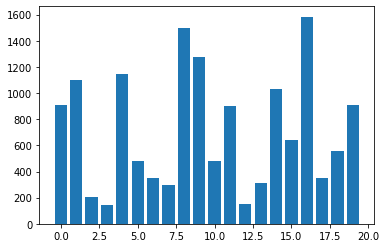

In [ ]:
import matplotlib.pyplot as plt
plt.bar(np.arange(20),[906,1102,204,140,1149,483,348,293,1496,1275,481,898,151,313,1028,638,1584,353,554,909])

<BarContainer object of 20 artists>

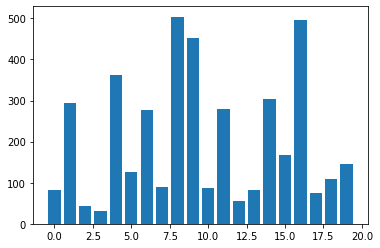

In [ ]:
plt.bar(np.arange(20),[82,293,43,32,363,127,277,89,504,453,87,279,56,82,304,168,497,74,110,145])

<BarContainer object of 20 artists>

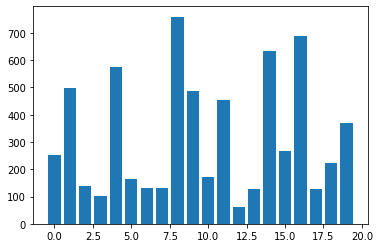

In [ ]:
plt.bar(np.arange(20),[251,496,138,103,575,164,132,130,759,488,172,455,60,127,633,268,687,127,223,371])

<BarContainer object of 20 artists>

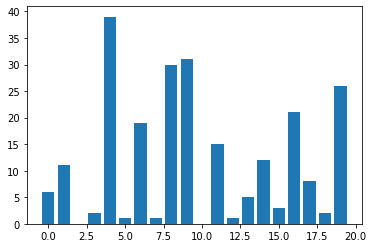

In [ ]:
plt.bar(np.arange(20),[6,11,0,2,39,1,19,1,30,31,0,15,1,5,12,3,21,8,2,26])